In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

In [24]:
def ribbon_gap(ribbon_homo, axis):
    if axis == "0":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif axis == "1":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff
    


In [25]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
def plot_ransac_revised(segment_data_x, segment_data_y):
    from skimage.measure import LineModelND, ransac
    data = np.column_stack([segment_data_x, segment_data_y])

    # fit line using all data
    model = LineModelND()
    model.estimate(data)

    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                                   residual_threshold=5, max_trials=1000)
    outliers = inliers == False

    # generate coordinates of estimated models
    line_x = np.array([segment_data_x.min(), segment_data_x.max()])
    line_y = model.predict_y(line_x)
    line_y_robust = model_robust.predict_y(line_x)
    k = (line_y_robust[1] - line_y_robust[0]) / (line_x[1] - line_x[0])
    m = line_y_robust[0] - k * line_x[0]
    x0 = (segment_data_y.min() - m) / k
    x1 = (segment_data_y.max() - m) / k
    line_x_y = np.array([x0, x1])
    line_y_robust_y = model_robust.predict_y(line_x_y)
    if (distance(line_x[0], line_y_robust[0], line_x[1], line_y_robust[1]) <
            distance(line_x_y[0], line_y_robust_y[0], line_x_y[1], line_y_robust_y[1])):
                # plt.plot(line_x, line_y_robust, '-b', label='Robust line model')
        line_twopoint = (line_x, line_y_robust)
    else:
                # plt.plot(line_x_y, line_y_robust_y, '-b', label='Robust line model')
        line_twopoint = (line_x_y, line_y_robust_y)

    return inliers, outliers, line_twopoint


def line_intersection(line1, line2, x_min, x_max, y_min, y_max):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    # 범위 내의 값인지 체크
    if x_min - 100 <= x <= x_max + 100 and y_min - 100 <= y <= y_max + 100:
        return x, y
    else:
        return -12345, -12345

def coord_sort(x):
    x = np.array(x)
    k = x[:,0]
    s = k.argsort()
    centers_sorted = x[s]
    for i in range(len(centers_sorted)//2):
        b = centers_sorted[2*i:2*(i+1),:]
        k = b[:,1]
        s = k.argsort()
        centers_sorted[2*i:2*(i+1), :] = b[s]
    return centers_sorted

def homography(img, points, width = 600, height = 300):
    pts1 = np.float32(coord_sort(points))
    pts2 = np.float32([[0, 0], [width, 0],[0,height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # img = img_to_coord(img)
    img = cv2.warpPerspective(img, matrix, (width, height))
    return img

def cluster(point_data, n_cluster=8):
    '''
    <input>
    point_data: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    n_cluster: 클러스터링할 그룹의 수

    <output>
    centers: 중심점 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    '''
    model = KMeans(n_clusters=n_cluster)
    model.fit(point_data)
    predict = model.predict(point_data)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(predict))))
    k_means_labels = model.labels_
    k_means_cluster_centers = model.cluster_centers_
    for k, col in zip(range(n_cluster), colors):
        my_members = (k_means_labels == k)

        # 중심 정의
        cluster_center = k_means_cluster_centers[k]

    centers = np.array(k_means_cluster_centers, dtype=int)
    return centers


def draw_dab_distances(centers):
    centers_x = centers[:,0]
    centers_y = centers[:,1]
    distances_vert = []
    distances_horiz = []
    for k in range(0, 6 ,2):
        distances_vert.append(round((centers[k]).distance((centers[k+1]))*2,2))
        plt.plot((centers_x[k], centers_x[k+1]),(centers_y[k],centers_y[k+1]), marker="o",linestyle=":")
        plt.text((centers_x[k]+centers_x[k+1])/2 ,(centers_y[k]+centers_y[k+1])/2, distances_vert[-1], color="white")
    for k in range(0, 4):
        distances_horiz.append(round((centers[k]).distance((centers[k+2]))*2,2))
        plt.plot((centers_x[k], centers_x[k+2]),(centers_y[k],centers_y[k+2]), marker="s",linestyle="--")
        plt.text((centers_x[k]+centers_x[k+2])/2 ,(centers_y[k]+centers_y[k+2])/2, distances_horiz[-1],color="white")

def ribbon_gap(ribbon_homo, axis):
    if axis == "0":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif axis == "1":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff

In [26]:
xy = np.load('../ribbon_point.npy')
img_dir = "../IMG_4245_JPG.rf.63460a44ffb7591e4ab7aaa7483d11e6.jpg"
img = cv2.imread(img_dir)

In [27]:
x_data = xy[:, 0]
y_data = xy[:, 1]
x_tmp = x_data.copy()
y_tmp = y_data.copy()
ransac_line = []
intersection_points = []
while True:
    inliers, outliers, line_twopoint = plot_ransac_revised(x_tmp, y_tmp)

    if x_tmp[inliers].shape[0] >= 2:
        # inliers, two points for line 기록 저장
        ransac_line.append((x_tmp[inliers], y_tmp[inliers], line_twopoint))

    # 나머지 점들 (outliers)
    x_tmp = x_tmp[outliers]
    y_tmp = y_tmp[outliers]

    # if x_tmp.shape[0] <= 2 or len(ransac_line) == 4:
    if len(ransac_line) == 4:
        break
x_min, x_max, y_min, y_max = x_data.min(), x_data.max(), y_data.min(), y_data.max()
for i in range(len(ransac_line)):
    for j in range(i + 1, len(ransac_line)):
        (x1, x2), (y1, y2) = ransac_line[i][2]
        (x3, x4), (y3, y4) = ransac_line[j][2]
        x, y = line_intersection([[x1, y1], [x2, y2]], [[x3, y3], [x4, y4]], x_min, x_max, y_min, y_max)
        if x != -12345 or y != -12345:
            intersection_points.append(np.array((x, y)))


intersection_points

[array([110.1796 , 463.13895], dtype=float32),
 array([242.68349, 151.67758], dtype=float32),
 array([438.00726, 493.12592], dtype=float32),
 array([441.69705, 164.74635], dtype=float32)]

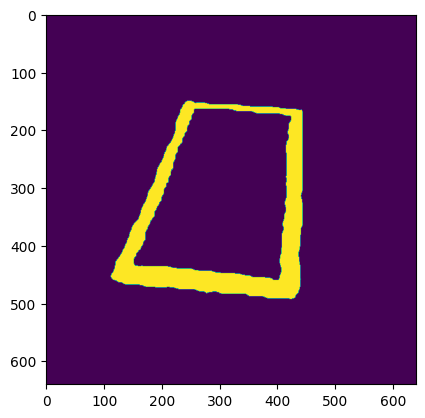

In [28]:
ribbon = np.load('../segmented8.npy')
plt.imshow(ribbon)
plt.show()

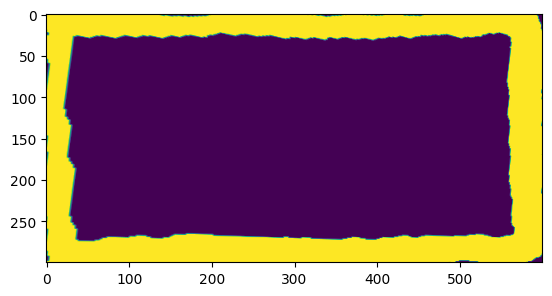

In [29]:
ribbon_homo = homography(ribbon, intersection_points)
plt.imshow(ribbon_homo)

In [30]:
x_gap = ribbon_gap(ribbon_homo, axis = "0") # axis = 0 : 행으로 절단해서 x value 사이의 거리를 구함
print(x_gap)

[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299 299 299 299 299 298 299 299 299 299 299 295 295  33  33  33  33
  33  33  32  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30
  30  30  30  30  30  30  29  26  26  27  27  27  27  27  26  26  26  27
  27  27  27  26  26  26  27  27  27  27  27  26  26  26  26  26  26  26
  25  25  25  25  25  25  25  25  24  24  24  24  24  24  24  23  23  23
  23  23  23  23  23  22  22  25  25  25  25  25  24  24  24  24  26  27
  27  27  29  29  29  29  29  29  32  31  31  31  31  31  31  31  30  30
  30  30  30  30  30  30  29  29  29  29  29  29  29  28  28  28  28  28
  28  28  28  27  27  27  26  26  27  27  26  27  29  29  29  29  32  31
  31  34  34  34  34  34  36  36  36  36  36  36  36  36  35  35  35  35
  35  35  35  34  34  34  34  34  34  34  34  33  33  33  33  33  33  33
  32  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30  30  30
  30  30  30  30  29  29  29  29  29  29  32  32  3

In [31]:
y_gap = ribbon_gap(ribbon_homo, axis = "1")
print(y_gap[:1000])

[149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 141 134  37  30  28
  28  28  27  27  28  28  28  28  28  28  29  29  29  29  29  30  30  30
  30  29  29  29  28  28  28  28  27  28  28  28  28  27  27  27  27  28
  28  28  28  28  29  29  29  29  29  30  30  30  30  30  31  29  30  30
  28  29  29  28  28  28  27  27  27  27  28  28  28  28  28  29  29  29
  29  29  30  30  29  29  29  28  28  28  27  27  27  28  28  28  28  28
  27  27  28  28  28  28  28  29  28  28  28  28  29  28  28  28  29  30
  28  28  26  27  27  25  25  25  24  25  25  25  25  25  26  26  27  27
  26  26  25  26  27  24  25  24  24  24  23  24  24  23  24  24  25  24
  24  25  25  26  26  25  26  26  27  27  28  25  26  27  27  28  26  26
  27  25  26  27  27  27  26  26  25  25  25  24  25  23  24  24  24  24
  25  25  25  25  25  26  26  26  26  27  27  27  27  27  28  27  27  27
  26  26  25  25  26  26  26  25  25  25  26  26  2

image의 해상도가 300*600이니, 각 픽셀별 거리는 실제 거리의 1/2임 따라서 25가 안되는 것들은 specification에 맞지 않음